# DATASET, DATALOADER

데이터 샘플을 처리하는 코드는 지저분(messy)하고 유지보수가 어려울 수 있다. <br> 
더 나은 가독성(readability)과 모듈성(modularity)을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적이다. <br> 
PyTorch는 torch.utils.data.DataLoader 와 torch.utils.data.Dataset의 두 가지 데이터 기본 요소를 제공하여 미리 준비해둔(pre-loaded) 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 한다. <br> Dataset 은 샘플과 정답(label)을 저장하고, DataLoader 는 Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다. <br> 

## 데이터셋 불러오기 

Fashion-MNIST는 Zalando의 기사 이미지 데이터셋으로 60,000개의 학습 예제와 10,000개의 테스트 예제로 이루어져 있다. <br> 
각 예제는 흑백(grayscale)의 28x28 이미지와 10개 분류(class) 중 하나인 정답(label)으로 구성된다.

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root = "data", # root 는 학습/테스트 데이터가 저장되는 경로
    train = True, # train 은 학습용 또는 테스트용 데이터셋 여부를 지정
    download = True, # download=True 는 root 에 데이터가 없는 경우 인터넷에서 다운로드
    transform = ToTensor() # transform 과 target_transform 은 특징(feature)과 정답(label) 변형(transform)을 지정
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

## 데이터셋을 순회하고 시각화하기

Dataset 에 리스트(list)처럼 직접 접근(index)할 수 있다. <br>
training_data[index]. matplotlib 을 사용하여 학습 데이터의 일부를 시각화한다. 

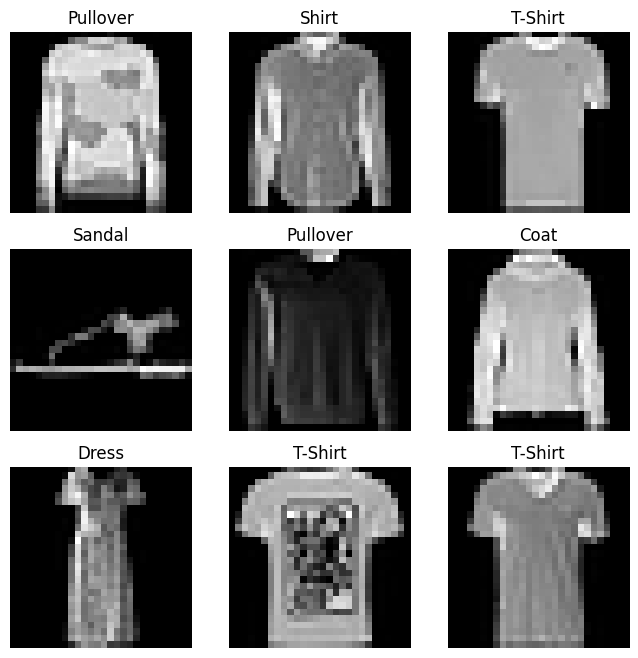

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize = (8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size = (1, )).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap = "gray")
plt.show()

## 파일에서 사용자 정의 데이터셋 만들기

사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 한다. <br> 
\__init__ , \__len__ , and \__getitem__. 
아래 코드를 살펴보면 FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, 정답은 annotations_file csv 파일에 별도로 저장된다.

In [4]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform = None, target_transform = None):
        self.img_labels = pd.read_csv(annotations_file, names = ['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### \__init__

\__init__ 함수는 Dataset 객체가 생성(instantiate)될 때 한 번만 실행된다. <br>
이미지와 주석 파일(annotation_file)이 포함된 디렉토리와 (다음 장에서 자세히 살펴볼) 두 가지 변형(transform)을 초기화한다. 

tshirt1.jpg, 0 <br>
tshirt2.jpg, 0 <br>
...... <br>
ankleboot999.jpg, 9 <br>

(labels.cvs file)

In [6]:
def __init__(self, annotations_file, img_dir, transform = None, target_transform = None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

### \__len__
\__len__ 함수는 데이터셋의 샘플 개수를 반환한다.

In [7]:
def __len__(self):
    return len(self.img_labels)

### \__getitem__

\__getitem__ 함수는 주어진 인덱스 idx 에 해당하는 샘플을 데이터셋에서 불러오고 반환한다. <br>
인덱스를 기반으로, 디스크에서 이미지의 위치를 식별하고, read_image 를 사용하여 이미지를 텐서로 변환하고, self.img_labels 의 csv 데이터로부터 해당하는 정답(label)을 가져오고, (해당하는 경우) 변형(transform) 함수들을 호출한 뒤, 텐서 이미지와 라벨을 Python 사전(dict)형으로 반환한다.

In [8]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    sample = {"image": image, "label": label}
    return sample

## DataLoader로 학습용 데이터 준비하기

Dataset 은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 한다. <br> 
모델을 학습할 때, 일반적으로 샘플들을 《미니배치(minibatch)》로 전달하고, 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고, Python의 multiprocessing 을 사용하여 데이터 검색 속도를 높이려고 한다. <br> 
DataLoader 는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)이다.

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

## DataLoader를 통해 순회하기(iterate)

DataLoader 에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있다. <br>
아래의 각 순회(iteration)는 (각각 batch_size=64 의 특징(feature)과 정답(label)을 포함하는) train_features 와 train_labels 의 묶음(batch)을 반환한다. <br>
shuffle=True 로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞인다.

Feature batch shape : torch.Size([64, 1, 28, 28])
Labels batch shape : torch.Size([64])


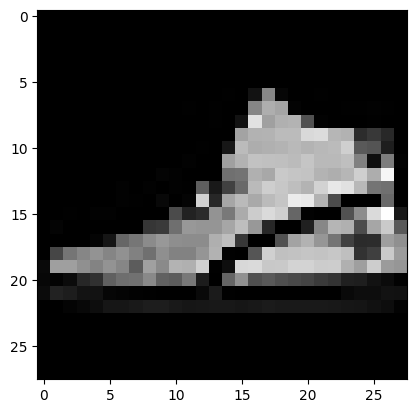

Label : 7


In [10]:
# 이미지와 정답(label)을 표시
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape : {train_features.size()}")
print(f"Labels batch shape : {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap = "gray")
plt.show()
print(f"Label : {label}")